In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error
from util import evaluate, plot_importance, plot_history

In [2]:
X_train = pd.read_parquet("./modelling_data/X_train.parquet")
y_train = pd.read_parquet("./modelling_data/y_train.parquet")["target"]
X_valid = pd.read_parquet("./modelling_data/X_validation.parquet")
y_valid = pd.read_parquet("./modelling_data/y_validation.parquet")["target"]

In [3]:
param_space = {
    "max_depth": hp.choice("max_depth", np.linspace(2, 10, 9, dtype=int)),
    "gamma": hp.choice("gamma", np.linspace(0, 5, 11)),
    "n_estimators": hp.choice("n_estimators", np.linspace(10, 400, 40, dtype=int)),
    "colsample_bytree": hp.choice("colsample_bytree", np.linspace(0.5, 1, 6)),
    "subsample": hp.quniform("subsample", 0.5, 1.0, 0.1),
    "eta": hp.uniform("eta", 0.05, 0.4),
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 0
}

In [4]:
def score(params):
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              early_stopping_rounds=10,
              verbose=False)
    y_pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, y_pred)
    return {"loss": score, "status": "ok"}

In [5]:
trials = Trials()
best_params_loc = fmin(score, param_space, algo=tpe.suggest, max_evals=200, trials=trials)
optimal_params = space_eval(param_space, best_params_loc)

100%|██████████| 200/200 [06:43<00:00,  2.02s/trial, best loss: 67.00853009240821]


In [6]:
optimal_params

{'colsample_bytree': 0.8,
 'eta': 0.09001878280534192,
 'eval_metric': 'rmse',
 'gamma': 0.0,
 'max_depth': 3,
 'n_estimators': 380,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'subsample': 0.9}

# Fit on entire train and evaluate on test set

In [7]:
X_train = pd.concat([X_train, X_valid])
y_train = pd.concat([y_train, y_valid])
X_test = pd.read_parquet("./modelling_data/X_test.parquet")
y_test = pd.read_parquet("./modelling_data/y_test.parquet")["target"]

In [8]:
model = xgb.XGBRegressor(**optimal_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=True
)

[0]	validation_0-rmse:121.99110	validation_1-rmse:121.75682
[1]	validation_0-rmse:111.06554	validation_1-rmse:110.90503
[2]	validation_0-rmse:101.13228	validation_1-rmse:101.03342
[3]	validation_0-rmse:92.09786	validation_1-rmse:92.07145
[4]	validation_0-rmse:83.88345	validation_1-rmse:83.86334
[5]	validation_0-rmse:76.41335	validation_1-rmse:76.43797
[6]	validation_0-rmse:69.62001	validation_1-rmse:69.70542
[7]	validation_0-rmse:63.44823	validation_1-rmse:63.52304
[8]	validation_0-rmse:57.84262	validation_1-rmse:57.94744
[9]	validation_0-rmse:52.74910	validation_1-rmse:52.88827
[10]	validation_0-rmse:48.12364	validation_1-rmse:48.26673
[11]	validation_0-rmse:43.92425	validation_1-rmse:44.02111
[12]	validation_0-rmse:40.11855	validation_1-rmse:40.19188
[13]	validation_0-rmse:36.66745	validation_1-rmse:36.73866
[14]	validation_0-rmse:33.54119	validation_1-rmse:33.64054
[15]	validation_0-rmse:30.71088	validation_1-rmse:30.83568
[16]	validation_0-rmse:28.15209	validation_1-rmse:28.28471
[

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.09001878280534192,
             eval_metric='rmse', gamma=0.0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0900187865,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=380, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9, tree_method='exact',
             validate_parameters=1, verbosity=None)

MAE = 5.2542924581821415
MSE = 65.28708528691729
RMSE = 8.080042406257364
MAPE = 0.040498672447626755
R^2 = 0.7089780645546673
Explained Variance Score = 0.7108388695757666

Residuals summary stats
╒═══════╤═══════════╕
│ count │     14534 │
├───────┼───────────┤
│ mean  │ -0.646102 │
├───────┼───────────┤
│ std   │   8.05445 │
├───────┼───────────┤
│ min   │  -46.2779 │
├───────┼───────────┤
│ 25%   │  -3.87507 │
├───────┼───────────┤
│ 50%   │  -1.59488 │
├───────┼───────────┤
│ 75%   │   2.21646 │
├───────┼───────────┤
│ max   │   51.2924 │
╘═══════╧═══════════╛

Deviation from mean of residuals
╒════════════╤══════════╤════════════╕
│ Interval   │   Actual │   Expected │
╞════════════╪══════════╪════════════╡
│ μ ± σ      │  83.1155 │       68.2 │
├────────────┼──────────┼────────────┤
│ μ ± 2σ     │  93.154  │       95.4 │
├────────────┼──────────┼────────────┤
│ μ ± 3σ     │  97.5299 │       99.7 │
╘════════════╧══════════╧════════════╛

Jarque-Bera Test on Residuals
╒═══════════

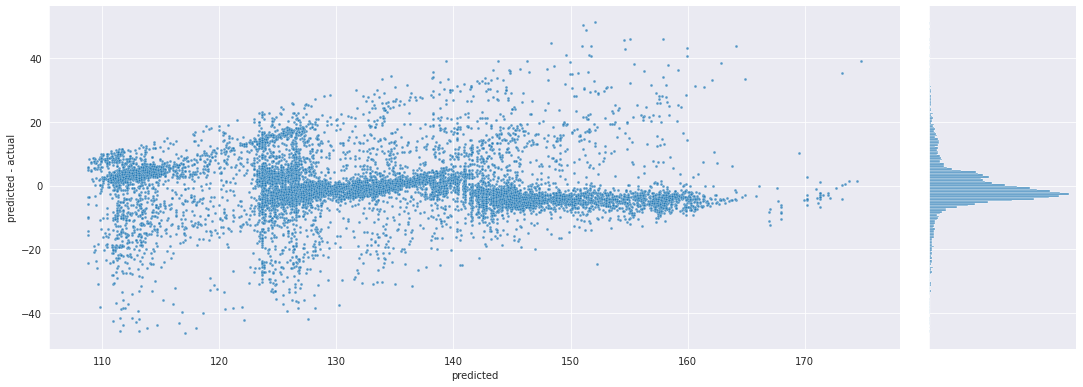

<Figure size 720x576 with 0 Axes>

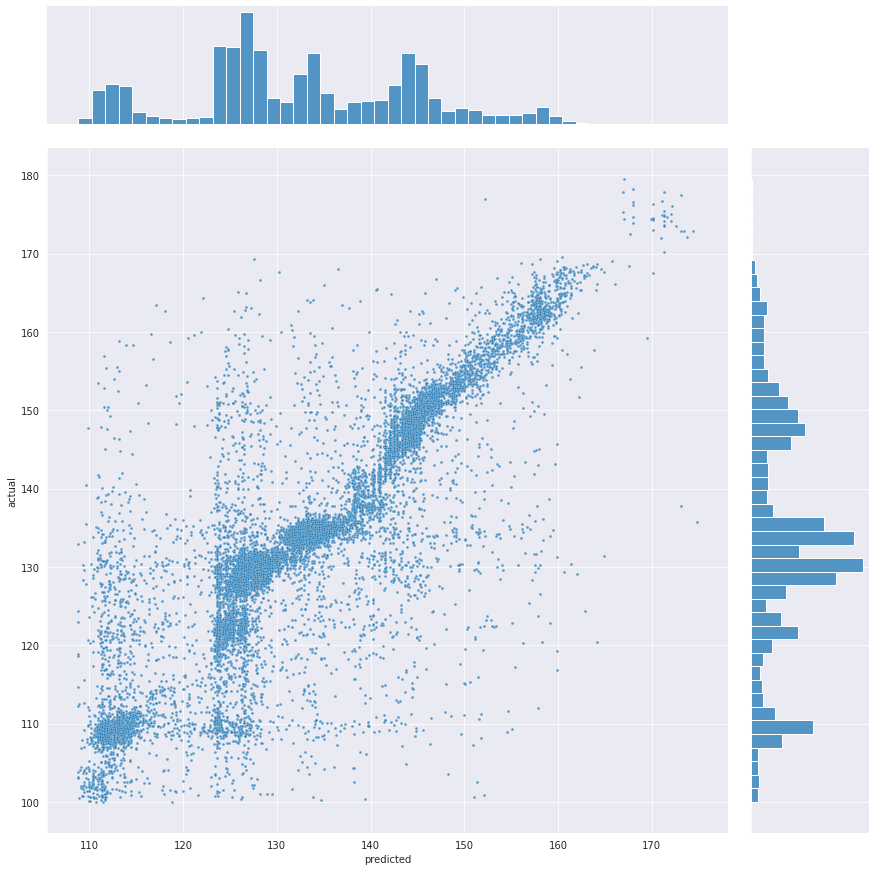

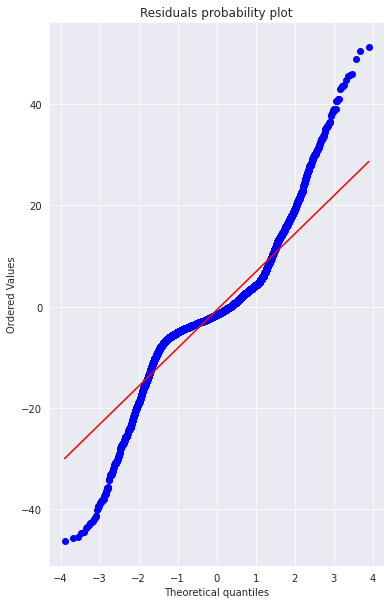

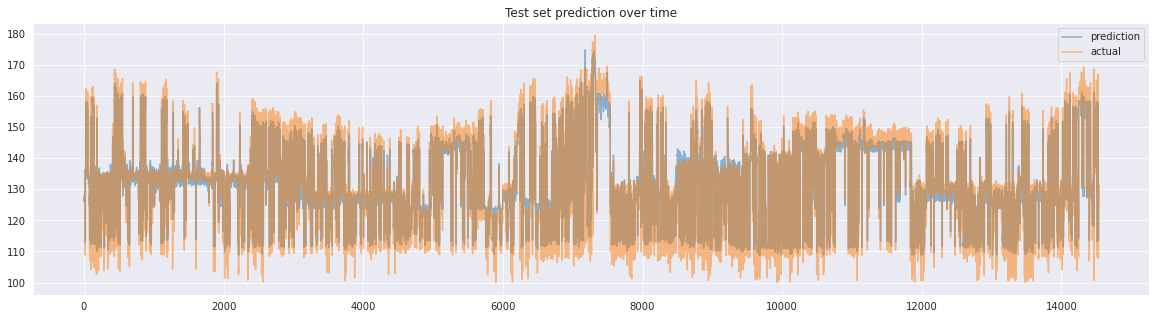

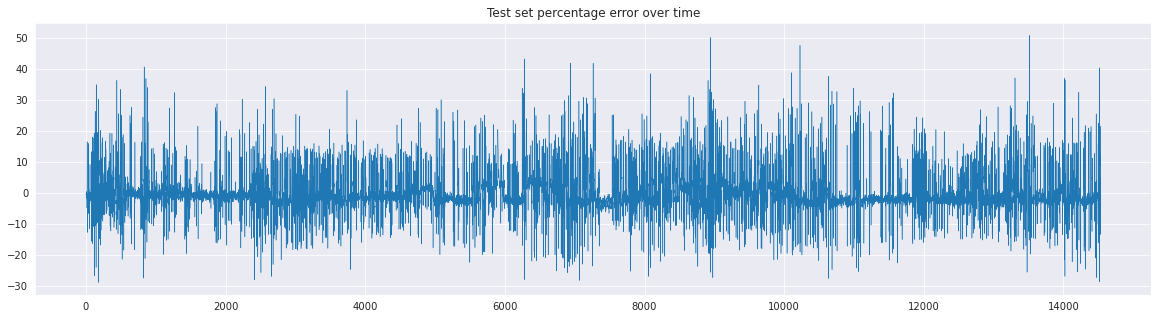

In [9]:
y_pred = model.predict(X_test)
evaluate(y_test.to_numpy(), y_pred)

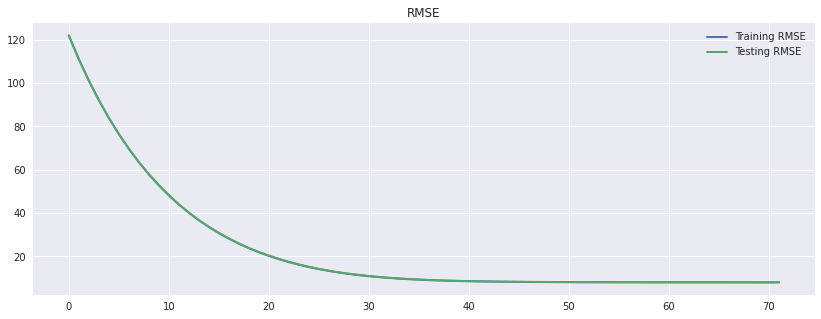

In [10]:
plot_history(model)

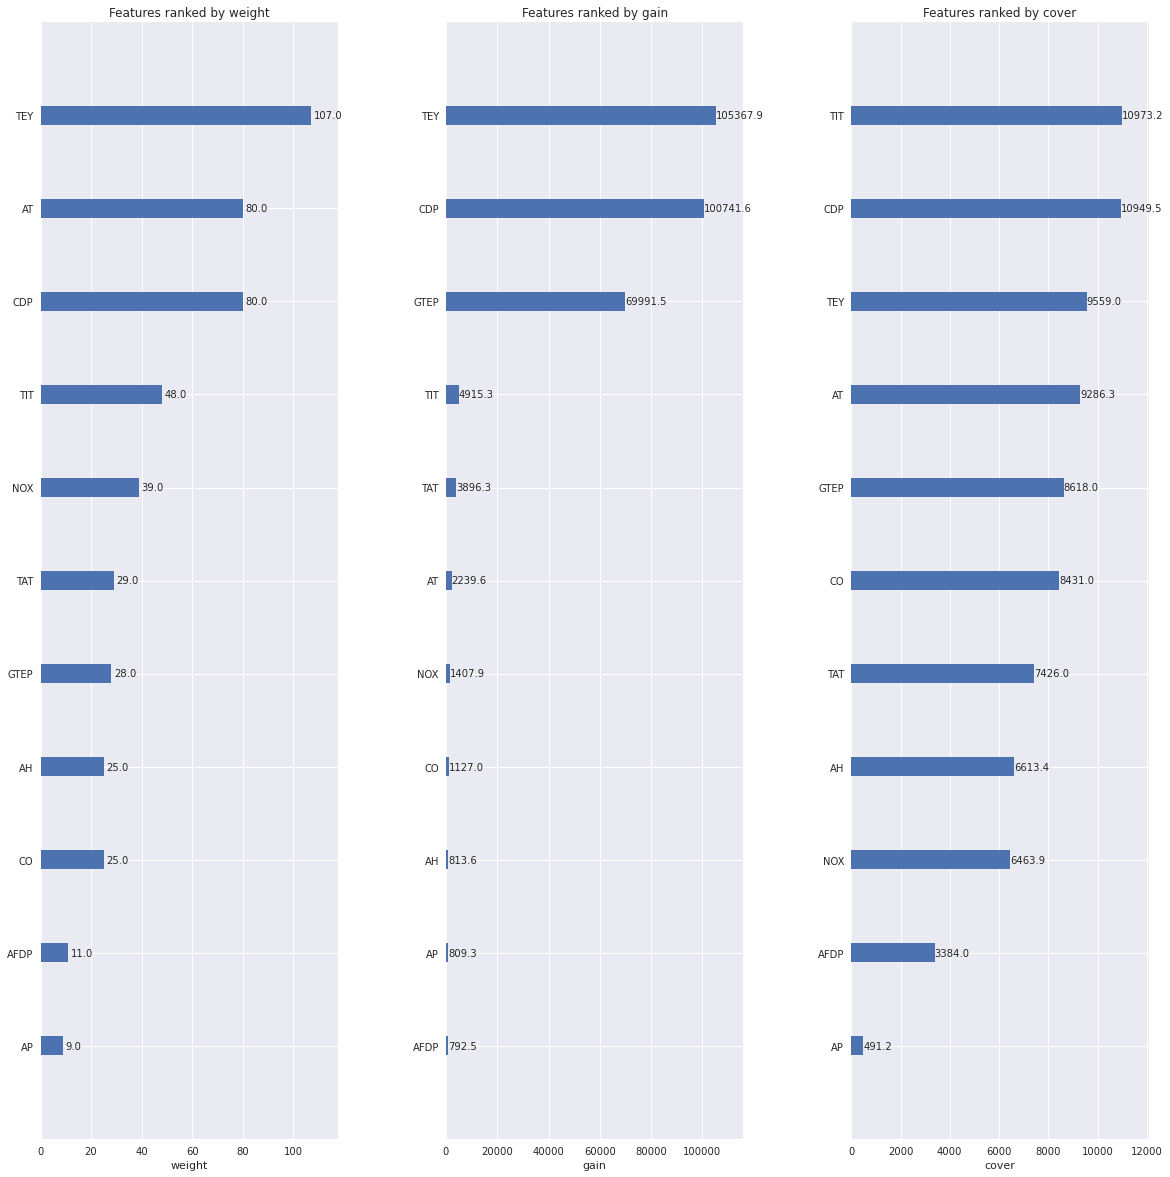

In [11]:
plot_importance(model)